In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from matplotlib import cm 
colors = cm.Reds(np.linspace(0.4, 0.9, 10))  # Gradient from light to dark red

import sys
sys.path.append('../../')

from src.viz import (
    plot_transition_matrix,
    plot_distribution,
    plot_implied_timescales,
)

#sns.set(style="white", context="notebook")

def extract_eigen_values(dict_in):
    # Extract spectrum per tau
    spectrum_tau = dict_in["spectrum_tau"]  # keys are strings, e.g. "1", "2", ...
    # Convert tau keys to integers and sort
    tau_list = sorted(map(int, spectrum_tau.keys()))
    # Initialize list of lists: eigval_curves[i][j] = i-th eigval at j-th tau
    eigval_curves = [[] for _ in range(10)]
    for tau in tau_list:
        eigvals = spectrum_tau[str(tau)]
        for i in range(min(10, len(eigvals))):
            eigval_curves[i].append(eigvals[i])
    return eigval_curves,tau_list

In [2]:

# Load the saved JSON
with open("../../data/toy_model/processed/markov_summary.json", "r") as f:
    data = json.load(f)

eigval_curves,tau_list = extract_eigen_values(data)

In [3]:
print(tau_list)

[1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200]


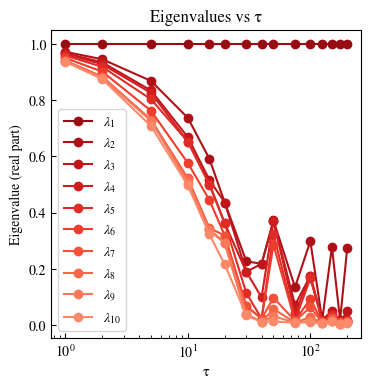

In [4]:

# Plot
fig,ax = plt.subplots(ncols=1,figsize=(4,4))
for i, eigs in enumerate(eigval_curves):
    ax.plot(tau_list, eigs,marker='o', label=r"$\lambda_{"+str(i+1)+"}$",color=colors[9-i])
ax.set_xlabel("τ")
ax.set_ylabel("Eigenvalue (real part)")
ax.set_title("Eigenvalues vs τ")
ax.set_xscale('log')
ax.legend()

#for i, eigs in enumerate(eigval_curves_tors):
#    ax[1].plot(tau_list_tors, eigs,marker='o', label=r"$\lambda_{"+str(i+1)+"}$",color=colors[9-i])
#ax[1].set_xlabel("τ")
#ax[1].set_ylabel("Eigenvalue (real part)")
#ax[1].set_title("Eigenvalues vs τ")
#ax[1].set_xscale('log')
#ax[1].legend()

First build the markov model associated with the clustering

In [5]:
# Paths to data from embed_and_cluster.py
with open("../../data/toy_model/processed/embedding.pkl", "rb") as f:
        emb = pickle.load(f)

print(f"Labels shape: {emb.labels}")
print(f"Embedding shape: {emb.embedding_matrix.shape}")


Labels shape: [11 11 11 ...  1  1  1]
Embedding shape: (1000, 968, 180)


Now have a look at the stationnary distribution

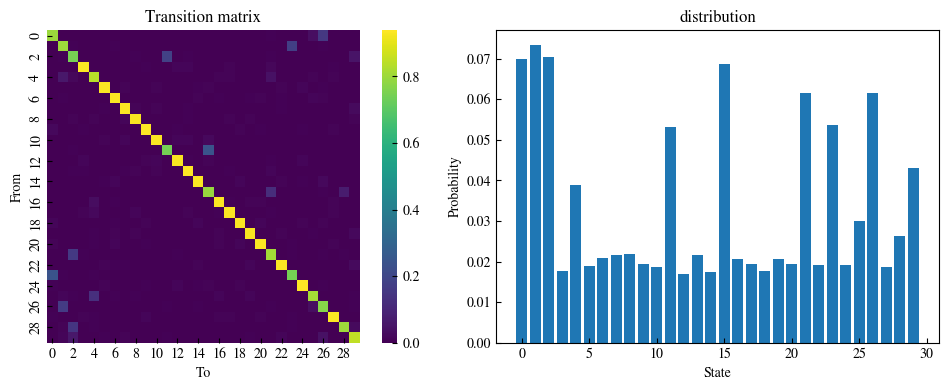

In [13]:
emb.make_transition_matrix(tau=1)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_transition_matrix(emb.P, ax=axs[0])
plot_distribution(emb.pi, ax=axs[1])
plt.tight_layout()


Text(0, 0.5, '# of points')

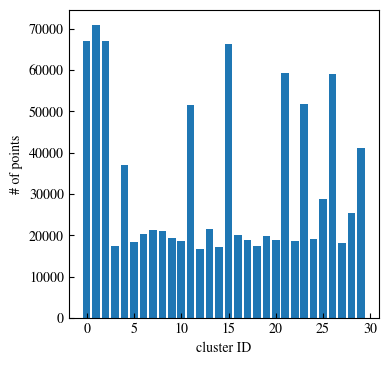

In [7]:
# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
# Optionally, zip into a dict
cluster_counts = dict(zip(unique_labels, counts))
fig,ax = plt.subplots(figsize=(4,4))
ax.bar(list(cluster_counts.keys()),list(cluster_counts.values()))
ax.set_xlabel('cluster ID')
ax.set_ylabel('# of points')

In [8]:
print(emb.Nsample)
print(emb.T)
print(emb.T-emb.K+1)
print(emb.labels.shape)
print(emb.embedding_matrix.shape)
print(emb.flatten_embedding_matrix.shape)

1000
997
968
(968000,)
(1000, 968, 180)
(968000, 180)


In [9]:
(emb.Nsample-1)*emb.T

996003

In [10]:
count = emb.count_transitions(emb.labels,n_clusters=emb.n_clusters, tau = 1,nsample = emb.Nsample,TmKp1 = emb.T-emb.K+1)
print(count[14])

[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0900e+02
 2.2500e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 1.6018e+04 0.0000e+00 0.0000e+00 0.0000e+00
 2.1000e+02 0.0000e+00 0.0000e+00 0.0000e+00 1.5600e+02 0.0000e+00
 1.0000e+02 2.0000e+00 3.5100e+02 0.0000e+00 0.0000e+00 0.0000e+00]


In [11]:
emb.P[14]

array([3.81656978e-03, 1.91415654e-02, 1.46791146e-02, 0.00000000e+00,
       7.04597499e-04, 4.50355235e-02, 8.76636721e-02, 3.05325583e-03,
       1.17432916e-04, 6.45881040e-04, 1.58534437e-03, 1.58534437e-03,
       1.35047854e-03, 0.00000000e+00, 4.79889613e-01, 4.69731666e-03,
       9.98179790e-04, 0.00000000e+00, 6.92854207e-02, 2.93582291e-03,
       5.16704832e-03, 8.22030415e-04, 6.59972990e-02, 1.17432916e-04,
       3.51124420e-02, 1.10974106e-02, 1.38923140e-01, 3.52298749e-04,
       0.00000000e+00, 5.22576478e-03])

In [12]:
with open("../../data/toy_model/processed/embedding.pkl", "wb") as f:
        pickle.dump(emb,f,protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
h = emb.entropy_rate(emb.P, emb.pi)
print(f"Shannon entropy rate: {h:.4f} bits per step")


Shannon entropy rate: 1.8413 bits per step


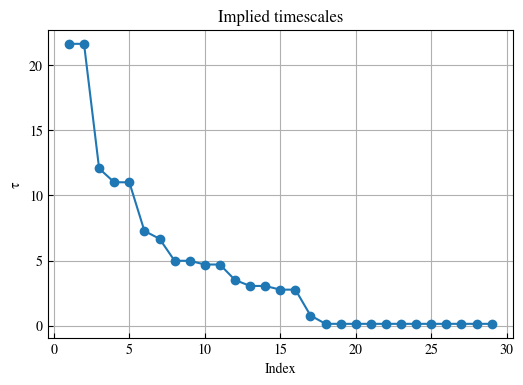

In [14]:
ts = emb.implied_timescales(emb.P, lag=emb.tau)

fig, ax = plt.subplots(figsize=(6, 4))
plot_implied_timescales(ts, ax=ax)


Look at the spectrum of the transition matrix.

[-5.97173073e-01 -5.20661982e-01 -5.04885258e-01 -5.04885258e-01
 -4.24867589e-01 -4.24867589e-01 -3.55671932e-01 -3.40284803e-01
 -3.40284803e-01 -3.07935370e-01 -3.07935370e-01 -2.53490204e-01
 -2.53490204e-01 -2.15326890e-01 -2.11851579e-01 -2.11851579e-01
 -1.74336656e-01 -1.74336656e-01 -1.55383940e-01 -1.55383940e-01
 -1.29181662e-01 -1.29181662e-01 -9.93073651e-02 -9.93073651e-02
 -9.28332768e-02 -9.28332768e-02 -6.13140020e-02 -6.13140020e-02
 -4.39771367e-02 -4.39771367e-02 -5.13297035e-03 -7.26804432e-16
 -5.74737831e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

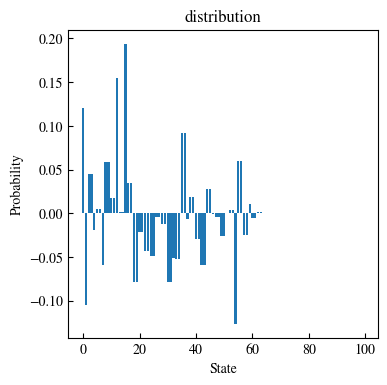

In [13]:
eig_val,eig_vec = np.linalg.eig(emb.P)
real_spectrum = np.real(eig_val)
eig_vec = eig_vec[np.argsort(real_spectrum)]
real_spectrum = real_spectrum[np.argsort(real_spectrum)]
print(real_spectrum)
fig,ax = plt.subplots(figsize=(4,4))
plot_distribution(np.real(eig_vec[-2]),ax = ax)
plt.show()

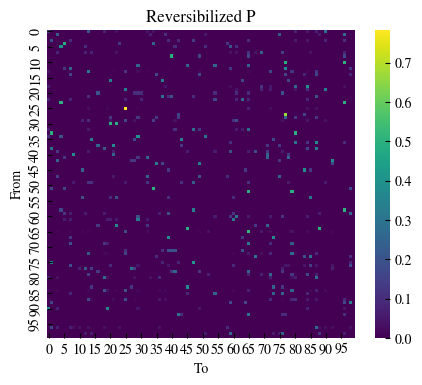

In [14]:
P_sym = emb.reversibilized_matrix()

fig, ax = plt.subplots(figsize=(5, 4))
plot_transition_matrix(P_sym, title="Reversibilized P", ax=ax)
